In [1]:
!pip install portalocker >& /dev/null

In [2]:
!python  -m spacy download en_core_web_sm dev >& /dev/null
!python  -m spacy download de_core_news_sm >& /dev/null

In [3]:
import torch
from torch import nn, Tensor
import torch.optim as optim
import torch.utils.data as data
from torchtext.datasets import Multi30k, multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from typing import Iterable, List
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Dataset

In [5]:
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [6]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.transpose(0,1), tgt_batch.transpose(0,1)

# Transformer Model

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # d_k equal fro d_q and d_v

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0,  -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output, attn_probs

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        attn_output, attn_probs = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output, attn_probs


In [8]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output, attn_probs = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x, attn_probs

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output, attn_probs_tgt = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output, attn_probs_cross = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x, attn_probs_tgt, attn_probs_cross

In [12]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, 5000)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != PAD_IDX).unsqueeze(1).unsqueeze(2).to(DEVICE)
        tgt_mask = (tgt != PAD_IDX).unsqueeze(1).unsqueeze(3).to(DEVICE)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(DEVICE)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def generate_mask_src(self,src):
        src_mask = (src != PAD_IDX).unsqueeze(1).unsqueeze(2).to(DEVICE)
        return src_mask


    def generate_mask_tgt(self, tgt):
        tgt_mask = (tgt != PAD_IDX).unsqueeze(1).unsqueeze(3).to(DEVICE)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(DEVICE)
        tgt_mask = tgt_mask & nopeak_mask
        return tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output, _ = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output, _ , _ = dec_layer(dec_output, enc_output, src_mask, tgt_mask)


        output = self.fc(dec_output)
        return output

    def encode(self, src):
        src_mask = self.generate_mask_src(src)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        enc_output = src_embedded
        att = {}
        for i, enc_layer in enumerate(self.encoder_layers):
            enc_output, attn_prob_enc = enc_layer(enc_output, src_mask)
            att[i] = attn_prob_enc
        return enc_output, src_mask, att

    def decode(self,tgt,memory,src_mask):
        tgt_mask = self.generate_mask_tgt(tgt)
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        dec_output = tgt_embedded

        att={}

        for i, dec_layer in enumerate(self.decoder_layers):
            dec_output, attn_prob_tgt, attn_prob_cross = dec_layer(dec_output, memory, src_mask, tgt_mask)
            att[i] = (attn_prob_tgt,attn_prob_cross)

        output = self.fc(dec_output)
        return output, att


# Training

In [13]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=batch_size, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:,:-1]

        logits = model(src,tgt_input)
        optimizer.zero_grad()

        tgt_out = tgt[:,1:]

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    src.detach(),tgt.detach(),logits.detach()


    return losses / len(list(train_dataloader))

def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=batch_size, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:,:-1]

        logits = model(src, tgt_input)

        tgt_out = tgt[:,1:]

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    src.detach(),tgt.detach(),logits.detach()

    return losses / len(list(val_dataloader))

In [45]:
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE])
d_model = 512
num_heads = 8
num_layers = 3
d_ff = 512
dropout = 0.1
batch_size = 128
NUM_EPOCHS = 10

In [46]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, dropout)
transformer = transformer.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.001)

In [47]:
for epoch in range(NUM_EPOCHS):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


Epoch: 0, Train loss: 3.539, Val loss: 2.606, Epoch time = 44.568s
Epoch: 1, Train loss: 2.311, Val loss: 2.254, Epoch time = 43.059s
Epoch: 2, Train loss: 1.871, Val loss: 2.133, Epoch time = 42.753s
Epoch: 3, Train loss: 1.574, Val loss: 2.098, Epoch time = 41.801s
Epoch: 4, Train loss: 1.341, Val loss: 2.099, Epoch time = 42.836s
Epoch: 5, Train loss: 1.162, Val loss: 2.114, Epoch time = 42.639s
Epoch: 6, Train loss: 1.027, Val loss: 2.152, Epoch time = 42.067s
Epoch: 7, Train loss: 0.914, Val loss: 2.168, Epoch time = 43.230s
Epoch: 8, Train loss: 0.830, Val loss: 2.227, Epoch time = 42.063s
Epoch: 9, Train loss: 0.759, Val loss: 2.251, Epoch time = 42.100s


# Inference

In [48]:
def greedy_decode(model, src, max_len, start_symbol):
    src = src.to(DEVICE)
    memory, src_mask, att_encode = model.encode(src)
    memory = memory.to(DEVICE)

    ys = torch.LongTensor([[start_symbol]]).to(DEVICE)  # Initialize with the start symbol

    for i in range(max_len-1):

        out, att_decode = model.decode(ys, memory, src_mask)

        _, next_word = torch.max(out[:,-1], dim=-1)
        next_word = next_word.item()

        ys = torch.cat((ys, torch.tensor([[next_word]],device=DEVICE)), dim=1)
        if next_word == EOS_IDX:
            break

    return ys, att_encode, att_decode

def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence)
    src = src.view(1,src.shape[0])
    num_tokens = src.shape[1]
    tgt_tokens, att_encode, att_decode = greedy_decode(model,  src, max_len=num_tokens + 5, start_symbol=BOS_IDX)
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(tgt_tokens.cpu().squeeze(0).numpy())).replace("<bos>", "").replace("<eos>", ""),att_encode, att_decode

In [49]:
sentence_trans,att_encode, att_decode = translate(transformer,"Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen")
print('Traslate : ',sentence_trans)

Traslate :   A group of men are loading products on a truck . 


In [50]:
sentence_trans = sentence_trans.strip()
attention_map_encoder = att_encode[2]
attention_map_decoder = att_decode[2][1]

sentence = "<bos> Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen <eos>"
sentence_tok_src = sentence.split(" ")
sentence_tok_tgt = sentence_trans.split(" ")
sentence_tok_tgt.insert(0,'<bos>')

# Encoder attention map

it's plot the attention weights concerning just the last encoder layer

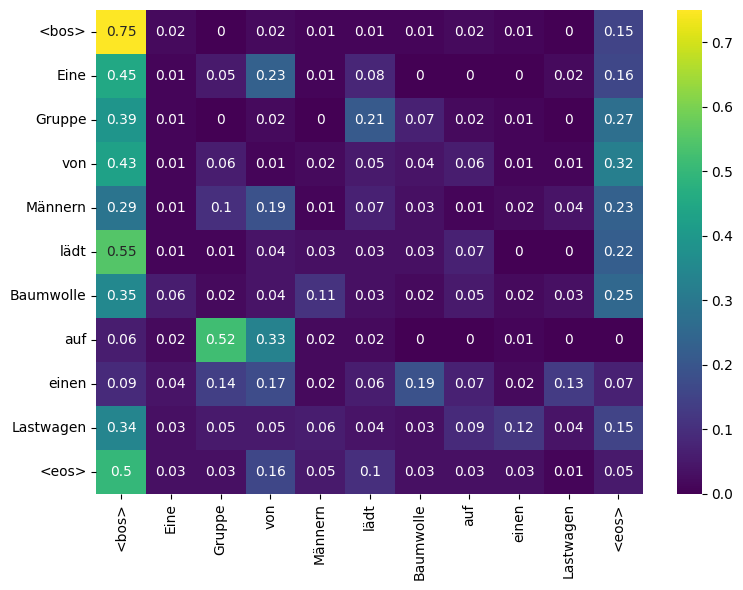

In [51]:
num_heads = attention_map_encoder.shape[1]
attention_matrix = attention_map_encoder[0, num_heads-1]
attention_np = attention_matrix.cpu().detach().numpy()
attention_np = np.round(attention_np,2)
plt.figure(figsize=(8, 6))
sns.heatmap(attention_np, annot=True, xticklabels=sentence_tok_src, yticklabels=sentence_tok_src, cmap="viridis", cbar=True)

plt.tight_layout()
plt.show()

# Decoder attention map

Attention weight concerning just the last decoder layer and in particular the attention weights concern the cross-attention of the transformer

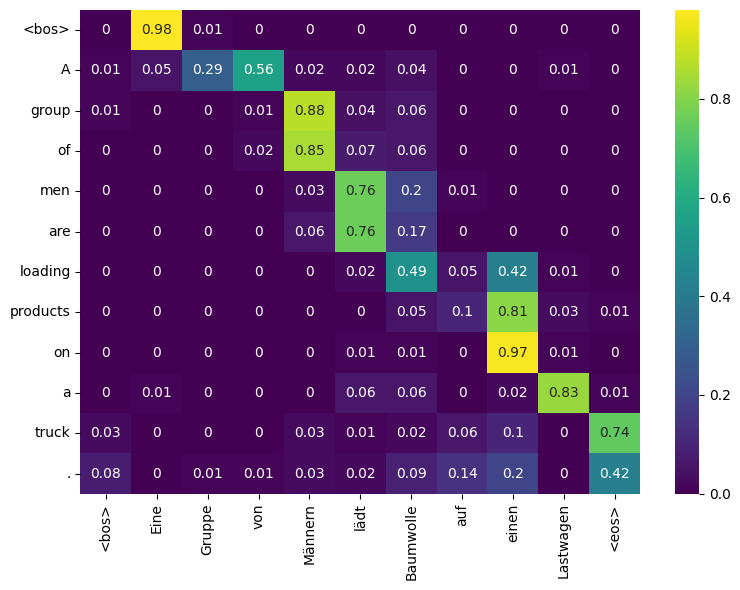

In [52]:
num_heads = attention_map_encoder.shape[1]
attention_matrix = attention_map_decoder[0, num_heads-1]
attention_np = attention_matrix.cpu().detach().numpy()
attention_np = np.round(attention_np,2)
plt.figure(figsize=(8, 6))
sns.heatmap(attention_np, annot=True, xticklabels=sentence_tok_src, yticklabels=sentence_tok_tgt, cmap="viridis", cbar=True)


plt.tight_layout()
plt.show()